## Problem Statement

SuperLender is a local digital lending company, which prides itself in its effective use of credit risk models to deliver profitable and high-impact loan alternative. Its assessment approach is based on two main risk drivers of loan default prediction:. 1) willingness to pay and 2) ability to pay. Since not all customers pay back, the company invests in experienced data scientist to build robust models to effectively predict the odds of repayment.

These two fundamental drivers need to be determined at the point of each application to allow the credit grantor to make a calculated decision based on repayment odds, which in turn determines if an applicant should get a loan, and if so - what the size, price and tenure of the offer will be.

There are two types of risk models in general: New business risk, which would be used to assess the risk of application(s) associated with the first loan that he/she applies. The second is a repeat or behaviour risk model, in which case the customer has been a client and applies for a repeat loan. In the latter case - we will have additional performance on how he/she repaid their prior loans, which we can incorporate into our risk model.

### Task
Build a model to predict if a loan was good or bad, i.e. accurately predict binary outcome variable, where Good is 1 and Bad is 0.

### Load the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot  as plt
import seaborn as sns

### Load the Datasets

In [2]:
traindemographics = pd.read_csv('loan datasets/traindemographics.csv')
trainperf =  pd.read_csv('loan datasets/trainperf.csv')
trainprev = pd.read_csv('loan datasets/trainprevloans.csv')

In [3]:
# Load the test set
testdemographics = pd.read_csv('loan datasets/testdemographics.csv')
testperf =  pd.read_csv('loan datasets/testperf.csv')
testprev = pd.read_csv('loan datasets/testprevloans.csv')

In [4]:
traindemographics.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [5]:
trainperf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


In [6]:
trainprev.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [7]:
print('The shape of the train demographics data is {}'.format(traindemographics.shape))
print('The shape of the train performance data is {}'.format(trainperf.shape))
print('The shape of the train previous data is {}'.format(trainprev.shape))

The shape of the train demographics data is (4346, 9)
The shape of the train performance data is (4368, 10)
The shape of the train previous data is (18183, 12)


- As seen, this is typical business problem where the data are stored in several tables in a database say loan database
- The demographics data of all customers are stored in the demographics table
- The data pertaining to previous loans and performance are stored in different tables.
- Some customers might have obtained several loans in the past so has several rows in the prev table
- The task is predict the if a loan will be good or bad based on the data available.
- The challenge will be to bring all the importance info from all three tables into a single table

**Let's take a closer look at the trainprev table**

In [8]:
trainprev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       18183 non-null  object 
 1   systemloanid     18183 non-null  int64  
 2   loannumber       18183 non-null  int64  
 3   approveddate     18183 non-null  object 
 4   creationdate     18183 non-null  object 
 5   loanamount       18183 non-null  float64
 6   totaldue         18183 non-null  float64
 7   termdays         18183 non-null  int64  
 8   closeddate       18183 non-null  object 
 9   referredby       1026 non-null   object 
 10  firstduedate     18183 non-null  object 
 11  firstrepaiddate  18183 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB


In [9]:
## function to convert the object date columns to datetime in loan previous table
def object_to_date(data : pd.DataFrame):
    data[['approveddate','creationdate','closeddate','firstduedate','firstrepaiddate']] =data[['approveddate','creationdate','closeddate','firstduedate','firstrepaiddate']].apply(pd.to_datetime);

##### preprocess the prev loan data;
* The goal is to:
1. form new columns from the data given such as a loan flag for each loan assuming a loan is good if the closeddate is less than the approved date plus termdays
2. get a summary dataframe that summarizes the previous loan record of a customer based on the average amount borrowed, avg amount due, prevloancount,prevgoodloan, lastloanflag and probality of such loan being good

In [10]:
#create function to perform step 1 above
def get_loanflag(data):
    data['repaymentperiod'] = (data['closeddate'] - data['approveddate']).dt.days
    data['firstpayperiod'] = (data['firstrepaiddate'] - data['approveddate']).dt.days
    loanflag = []
    for i in data.index:
        if data['repaymentperiod'][i] > data['termdays'][i]:
            loanflag.append(0)
        else: loanflag.append(1)

    data['loanflag'] = loanflag

##### Create a new dataframe that contains a summary of each customers previous loan 

In [11]:
def prev_summary(data) : 
    newprev = data.groupby('customerid', sort= False)[['loanamount','totaldue']].mean()
    newprev['prevloancount'] =  data.groupby('customerid',sort= False)['loanflag'].count()
    newprev['prevgoodcount'] = data.groupby('customerid',sort= False)['loanflag'].sum()
    newprev['probofpay'] = newprev['prevgoodcount']/newprev['prevloancount']
    lastloanstatus = data.sort_values(by='approveddate', ascending=False).groupby('customerid')['loanflag'].first()
    summarydata = newprev.reset_index().merge(lastloanstatus.reset_index(),on='customerid')
    return summarydata

##### apply functions above on train prev data

In [12]:
object_to_date(trainprev)
get_loanflag(trainprev)
trainprevsummary = prev_summary(trainprev)

In [13]:
trainprevsummary = trainprevsummary.rename(columns={'loanamount':'avprevloanamount','totaldue':'avgprevtotaldue'})
trainprevsummary.head()

,customerid,avprevloanamount,avgprevtotaldue,prevloancount,prevgoodcount,probofpay,loanflag
0,8a2a81a74ce8c05d014cfb32a0da1049,18181.818182,22081.818182,11,8,0.727273,1
1,8a8588f35438fe12015444567666018e,10000.000000,11750.000000,6,5,0.833333,1
2,8a85890754145ace015429211b513e16,10000.000000,12250.000000,2,0,0.000000,0
3,8a858970548359cc0154883481981866,18750.000000,23550.000000,8,8,1.000000,1
4,8a8589f35451855401546b0738c42524,14285.714286,17828.571429,7,6,0.857143,1


##### apply functions above to test prev data

In [14]:
object_to_date(testprev)
get_loanflag(testprev)
testprevsummary = prev_summary(testprev)

In [15]:
testprevsummary = testprevsummary.rename(columns={'loanamount':'avprevloanamount','totaldue':'avgprevtotaldue'})
testprevsummary.head()

,customerid,avprevloanamount,avgprevtotaldue,prevloancount,prevgoodcount,probofpay,loanflag
0,8a858899538ddb8e015390510b321f08,8666.666667,10966.666667,3,2,0.666667,1
1,8a858959537a097401537a4e316e25f7,23888.888889,27600.000000,9,8,0.888889,1
2,8a8589c253ace09b0153af6ba58f1f31,13000.000000,15935.000000,5,2,0.400000,1
3,8a858e095aae82b7015aae86ca1e030b,17142.857143,19342.857143,7,7,1.000000,1
4,8a858e225a28c713015a30db5c48383d,10000.000000,12500.000000,3,3,1.000000,1


### Merge tables
That is merging the customerdemographics table, the performance table and the prev loan summary table to a single dataframe.
NB: merge will be on the customer ID and based on the performance table.

In [16]:
## merge trainprevsummary demographics to pref data
df1 = trainprevsummary.merge(trainperf,how='right',on='customerid')
## the merge customer data to the new dataframe
train_df = traindemographics.merge(df1,how='right',on='customerid')

In [17]:
#do same for test
df2 = testprevsummary.merge(testperf,how='right',on='customerid')
## the merge customer data to the new dataframe
test_df = testdemographics.merge(df2,how='right',on='customerid')

### Explore the data
We now have the train and test data as a single dataframe, its time to perform some expository data analysis on it

In [18]:
## see a preview of the train data
train_df.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,avprevloanamount,...,loanflag,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate,18181.818182,...,1.0,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,1985-08-23 00:00:00.000000,Savings,3.885298,7.320700,GT Bank,"DUGBE,IBADAN",Permanent,Graduate,NaN,...,NaN,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,1984-09-18 00:00:00.000000,Other,11.139350,10.292041,EcoBank,NaN,Permanent,NaN,10000.000000,...,1.0,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,1977-10-10 00:00:00.000000,Savings,3.985770,7.491708,First Bank,NaN,Permanent,NaN,10000.000000,...,0.0,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,1986-09-07 00:00:00.000000,Other,7.457913,9.076574,GT Bank,NaN,Permanent,Primary,18750.000000,...,1.0,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


#### Check for missing values

In [19]:
#function to check missing columns in dataframe
def plot_missing(data : pd.DataFrame) :
  size = data.shape[0]
  missing = data.isnull().sum()[data.isnull().sum() > 0].sort_values()
  if not missing.empty :
    plot_bar(missing, size)
  else:
    print('This data contains no missing columns')

In [20]:
#function that plots missing values
def plot_bar(data : pd.Series, size):
  ax = data.plot.barh()

  for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/size)*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

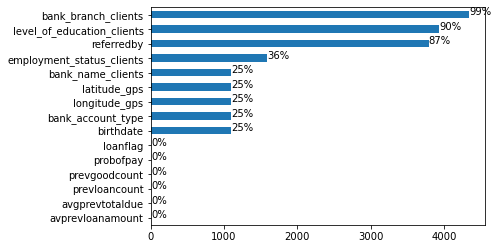

In [21]:
plot_missing(train_df)

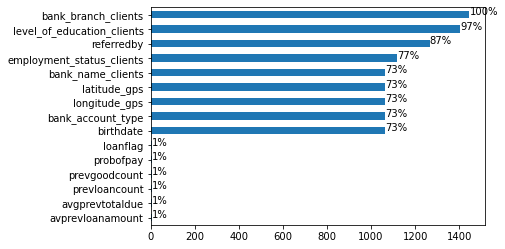

In [22]:
plot_missing(test_df)

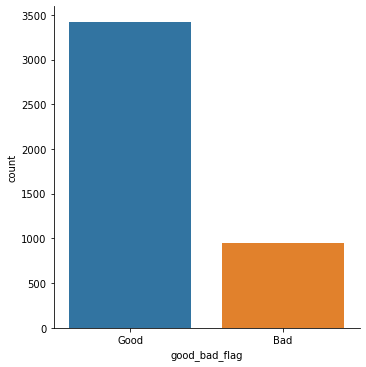

In [23]:
## explore target
sns.catplot(data=train_df,x='good_bad_flag',kind='count')

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4376 entries, 0 to 4375
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  4376 non-null   object 
 1   birthdate                   3277 non-null   object 
 2   bank_account_type           3277 non-null   object 
 3   longitude_gps               3277 non-null   float64
 4   latitude_gps                3277 non-null   float64
 5   bank_name_clients           3277 non-null   object 
 6   bank_branch_clients         33 non-null     object 
 7   employment_status_clients   2784 non-null   object 
 8   level_of_education_clients  443 non-null    object 
 9   avprevloanamount            4367 non-null   float64
 10  avgprevtotaldue             4367 non-null   float64
 11  prevloancount               4367 non-null   float64
 12  prevgoodcount               4367 non-null   float64
 13  probofpay                   4367 

In [25]:
train_df.describe()

,longitude_gps,latitude_gps,avprevloanamount,avgprevtotaldue,prevloancount,prevgoodcount,probofpay,loanflag,systemloanid,loannumber,loanamount,totaldue,termdays
count,3277.000000,3277.000000,4367.000000,4367.000000,4367.000000,4367.000000,4367.000000,4367.000000,4.376000e+03,4376.000000,4376.000000,4376.000000,4376.000000
mean,4.534611,7.292799,12906.529204,15636.199383,4.168308,3.304099,0.770010,0.742844,3.019810e+08,5.169333,17803.930530,21252.565288,29.266453
std,7.916626,3.268758,4816.675389,5377.329202,3.653928,3.249305,0.325196,0.437116,1.342393e+04,3.652679,10749.041391,11943.706857,11.513424
min,-118.247009,-33.868818,5000.000000,5750.000000,1.000000,0.000000,0.000000,0.000000,3.019585e+08,2.000000,10000.000000,10000.000000,15.000000
25%,3.354984,6.473645,10000.000000,12250.000000,1.000000,1.000000,0.666667,0.000000,3.019691e+08,2.000000,10000.000000,13000.000000,30.000000
50%,3.587546,6.625954,10000.000000,13000.000000,3.000000,2.000000,1.000000,1.000000,3.019801e+08,4.000000,10000.000000,13000.000000,30.000000
75%,6.478157,7.429882,14285.714286,17300.000000,6.000000,5.000000,1.000000,1.000000,3.019935e+08,7.000000,20000.000000,24500.000000,30.000000
max,151.209290,71.228069,36666.666667,41252.380952,26.000000,26.000000,1.000000,1.000000,3.020040e+08,27.000000,60000.000000,68100.000000,90.000000


In [26]:
train_df.corr()

,longitude_gps,latitude_gps,avprevloanamount,avgprevtotaldue,prevloancount,prevgoodcount,probofpay,loanflag,systemloanid,loannumber,loanamount,totaldue,termdays
longitude_gps,1.000000,-0.253237,0.006664,0.008349,-0.007705,-0.002858,0.018619,0.017434,-0.008483,-0.007593,-0.001301,-0.001766,0.003204
latitude_gps,-0.253237,1.000000,-0.012489,-0.013346,-0.000618,-0.000627,-0.026107,-0.022440,-0.004570,-0.000543,0.010006,0.007852,-0.008003
avprevloanamount,0.006664,-0.012489,1.000000,0.992294,0.850910,0.858988,0.150602,0.113376,-0.027046,0.852442,0.889600,0.871269,0.477949
avgprevtotaldue,0.008349,-0.013346,0.992294,1.000000,0.834790,0.842964,0.148911,0.115162,-0.023764,0.836493,0.882754,0.870014,0.522944
prevloancount,-0.007705,-0.000618,0.850910,0.834790,1.000000,0.939737,0.079515,0.064963,-0.046570,0.999701,0.832820,0.814906,0.405368
prevgoodcount,-0.002858,-0.000627,0.858988,0.842964,0.939737,1.000000,0.313154,0.251487,-0.042986,0.939535,0.858369,0.839756,0.428206
probofpay,0.018619,-0.026107,0.150602,0.148911,0.079515,0.313154,1.000000,0.781793,0.001009,0.079489,0.191058,0.190071,0.093193
loanflag,0.017434,-0.022440,0.113376,0.115162,0.064963,0.251487,0.781793,1.000000,-0.002761,0.065094,0.169342,0.168098,0.089420
systemloanid,-0.008483,-0.004570,-0.027046,-0.023764,-0.046570,-0.042986,0.001009,-0.002761,1.000000,-0.046517,-0.057344,-0.061673,-0.065447
loannumber,-0.007593,-0.000543,0.852442,0.836493,0.999701,0.939535,0.079489,0.065094,-0.046517,1.000000,0.833489,0.815476,0.405449


#### Visualize the data

Text(0.5, 1.0, 'Latitude Distribution')

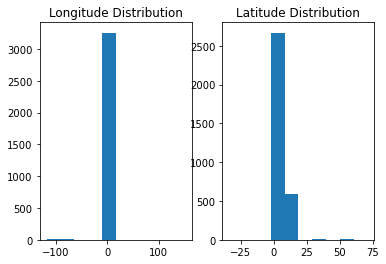

In [27]:
## see distribution of location
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(train_df.longitude_gps)
ax1.set_title('Longitude Distribution')
ax2.hist(train_df.latitude_gps)
ax2.set_title('Latitude Distribution')

<AxesSubplot:xlabel='longitude_gps', ylabel='latitude_gps'>

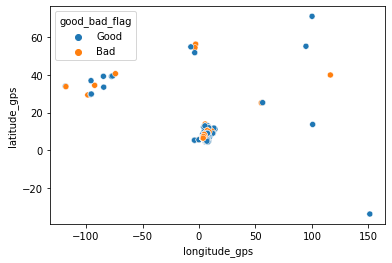

In [28]:
##plot the different locations on a scatter plot
sns.scatterplot(data=train_df,x='longitude_gps', y='latitude_gps', hue='good_bad_flag')

<AxesSubplot:xlabel='probofpay', ylabel='Count'>

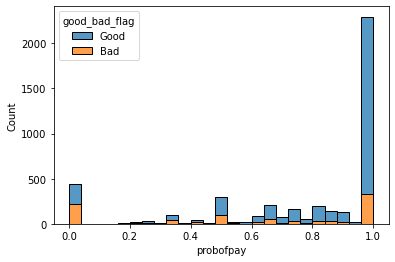

In [29]:
sns.histplot(data=train_df,x='probofpay',hue='good_bad_flag',multiple='stack')

<AxesSubplot:xlabel='loanflag', ylabel='count'>

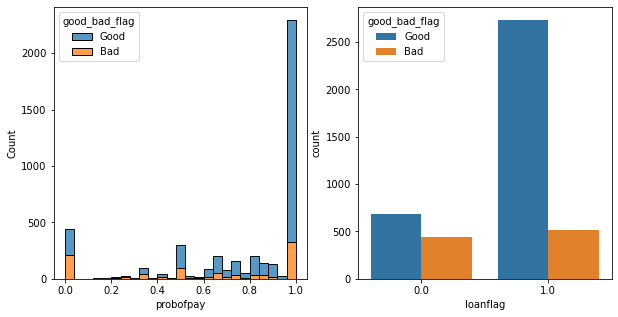

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
sns.histplot(data=train_df,x='probofpay',hue='good_bad_flag',multiple='stack',ax=ax1)
sns.countplot(data=train_df,x='loanflag',hue='good_bad_flag',ax=ax2)

In [31]:
train_df.groupby(['employment_status_clients','good_bad_flag'])['good_bad_flag'].count()

employment_status_clients  good_bad_flag
Contract                   Good                1
Permanent                  Bad               482
                           Good             1866
Retired                    Good                4
Self-Employed              Bad                45
                           Good              232
Student                    Bad                30
                           Good               81
Unemployed                 Bad                 7
                           Good               36
Name: good_bad_flag, dtype: int64

In [32]:
train_df.groupby(['bank_account_type','good_bad_flag'])['good_bad_flag'].count()

bank_account_type  good_bad_flag
Current            Bad                 5
                   Good               41
Other              Bad                88
                   Good              565
Savings            Bad               621
                   Good             1957
Name: good_bad_flag, dtype: int64

In [33]:
train_df['bank_name_clients'].value_counts()

GT Bank               1210
First Bank             430
Access Bank            329
UBA                    269
Zenith Bank            224
Diamond Bank           216
Stanbic IBTC           117
EcoBank                116
FCMB                    89
Skye Bank               76
Fidelity Bank           74
Sterling Bank           43
Wema Bank               19
Heritage Bank           18
Union Bank              15
Keystone Bank           14
Standard Chartered      13
Unity Bank               5
Name: bank_name_clients, dtype: int64

## Prepare Data

- Extract the target column
- Join the train and test features data for easy processing
- Get columns with missing values
- Drop columns with over 80% missing values
- Look for the best way to fill missing values

In [34]:
##make a copy of the train and test data
train_df1 = train_df.copy()
test_df1 = test_df.copy()

In [35]:
##redex index of test_df so it canbe join with train for preprocessing
start_index = train_df1.index.max() +1
end_index = start_index+test_df1.index.max()+1
new_test_index = range(start_index,end_index)
test_df1['index_col'] = new_test_index
test_df1 = test_df1.set_index('index_col')

In [36]:
##Extract target from train data
y_train = train_df1['good_bad_flag']

In [37]:
#join train and test data as df
df = pd.concat([train_df1.drop('good_bad_flag',axis=1),test_df1])

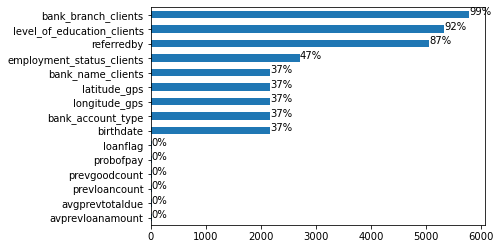

In [38]:
#check null in df
plot_missing(df)

In [39]:
#drop columns with over 80% null values
df = df.drop(['bank_branch_clients','level_of_education_clients','referredby'],axis=1)

In [40]:
## see employment status column
df['employment_status_clients'].value_counts()

Permanent        2629
Self-Employed     308
Student           127
Unemployed         46
Retired             5
Contract            1
Name: employment_status_clients, dtype: int64

In [41]:
## its best to fill it with another category others
df['employment_status_clients'].fillna('Others', inplace=True)

In [42]:
## bank and account type
df['bank_name_clients'].value_counts()

GT Bank               1347
First Bank             487
Access Bank            364
UBA                    303
Zenith Bank            249
Diamond Bank           244
Stanbic IBTC           129
EcoBank                126
FCMB                   107
Skye Bank               85
Fidelity Bank           81
Sterling Bank           46
Wema Bank               22
Union Bank              20
Heritage Bank           19
Keystone Bank           14
Standard Chartered      13
Unity Bank               6
Name: bank_name_clients, dtype: int64

In [43]:
df['bank_account_type'].value_counts()

Savings    2887
Other       723
Current      52
Name: bank_account_type, dtype: int64

In [44]:
## fill this two columns with the mode
df['bank_account_type'] = df['bank_account_type'].fillna('Savings')
df['bank_name_clients'] = df['bank_name_clients'].fillna('GT Bank')

In [45]:
## Longitude and latitude
## as seen in the distribution plot, this column has lots of outlier values, fill the missing vales with the median
df['longitude_gps'] = df['longitude_gps'].fillna(df['longitude_gps'].median())
df['latitude_gps'] = df['latitude_gps'].fillna(df['latitude_gps'].median())

In [46]:
## for birthday, get the mode value of birthyear, then use it to fill the missing values
# Then convert the column to datetime
mode_year = pd.to_datetime(df['birthdate'],errors='coerce').dt.year.mode()
mode_year

0    1986.0
dtype: float64

In [47]:
df['birthdate'] = df['birthdate'].fillna('1986-06-10 00:00:00.000000')

In [48]:
df['birthdate'] = pd.to_datetime(df['birthdate'])

Next having null values in the prevloan summary details means that particular customer hasnt taken a loan.
It will be best to fil these values with a different category for categorical columns and 0 for numerical columns

In [49]:
# loanflag contains the flag for the last loan taken by the customer, since the person hasnt taken before, fill it with say 2.
# filling with two means we will have to process it later using onehotencoding
df['loanflag'] = df['loanflag'].fillna(2)

In [50]:
df['probofpay'] = df['probofpay'].fillna(0)
df['prevgoodcount'] = df['prevgoodcount'].fillna(0)
df['prevloancount'] = df['prevloancount'].fillna(0)
df['avgprevtotaldue'] = df['avgprevtotaldue'].fillna(0)
df['avprevloanamount'] = df['avprevloanamount'].fillna(0)

In [51]:
#confirm there ae no missing values
df.isnull().sum().sum()

0

## Feature Selection

Drop approved date, creationdate, and birthdate

In [52]:
df = df.drop(['creationdate','approveddate','birthdate','customerid'],axis=1)

## Feature Engineering

- The bank_name_clients column has lots of distinct values. Reduce it to three values

In [53]:
top_banks = ['First Bank','Access Bank','UBA','Zenith Bank','Diamond Bank','Stanbic IBTC','EcoBank','FCMB']
banks = []
for i in df['bank_name_clients'].index:
    if df['bank_name_clients'][i] in top_banks:
        banks.append('Top_banks')
    elif df['bank_name_clients'][i] == 'GT Bank':
        banks.append('GT Bank')
    else:
        banks.append('Others')
        
df['bank_name_clients'] = banks

In [54]:
df['bank_name_clients'].value_counts()

GT Bank      3511
Top_banks    2009
Others        306
Name: bank_name_clients, dtype: int64

In [55]:
df['loanflag'] = df['loanflag'].astype('category')

In [56]:
df['loanflag'].dtype

CategoricalDtype(categories=[0.0, 1.0, 2.0], ordered=False)

In [57]:
# get dummies for categorical and object types
df = pd.get_dummies(data=df)

In [58]:
df

,longitude_gps,latitude_gps,avprevloanamount,avgprevtotaldue,prevloancount,prevgoodcount,probofpay,systemloanid,loannumber,loanamount,...,employment_status_clients_Contract,employment_status_clients_Others,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,loanflag_0.0,loanflag_1.0,loanflag_2.0
0,3.432010,6.433055,18181.818182,22081.818182,11.0,8.0,0.727273,301994762,12,30000.0,...,0,0,1,0,0,0,0,0,1,0
1,3.885298,7.320700,0.000000,0.000000,0.0,0.0,0.000000,301965204,2,15000.0,...,0,0,1,0,0,0,0,0,0,1
2,11.139350,10.292041,10000.000000,11750.000000,6.0,5.0,0.833333,301966580,7,20000.0,...,0,0,1,0,0,0,0,0,1,0
3,3.985770,7.491708,10000.000000,12250.000000,2.0,0.0,0.000000,301999343,3,10000.0,...,0,0,1,0,0,0,0,1,0,0
4,7.457913,9.076574,18750.000000,23550.000000,8.0,8.0,1.000000,301962360,9,40000.0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,3.587857,6.627635,10000.000000,11500.000000,2.0,2.0,1.000000,301991141,3,10000.0,...,0,1,0,0,0,0,0,0,1,0
5822,3.587857,6.627635,10000.000000,11500.000000,2.0,2.0,1.000000,301963018,3,10000.0,...,0,1,0,0,0,0,0,0,1,0
5823,3.587857,6.627635,18125.000000,22075.000000,8.0,6.0,0.750000,301994653,9,40000.0,...,0,1,0,0,0,0,0,1,0,0
5824,3.587857,6.627635,30384.615385,36084.615385,13.0,13.0,1.000000,301961483,14,60000.0,...,0,1,0,0,0,0,0,0,1,0


In [59]:
#convert target column to numerical
y_train = y_train.map({'Good':1, 'Bad':0})

## Model Building

- import the neccessary libraries for model model
- Build serveral models and choose the best
- Use accuracy as the evaluation metrics since ranking is done base percentage of loan one predicts incorrectly ie 1-accuracy_score. This might change depending business objective

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Build a base model with logisticregressor

In [61]:
# get the train data
X = df.loc[0:start_index-1, :]

In [62]:
## then scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X)

In [63]:
## fit a logistics model to train_X
log_model = LogisticRegression(random_state=0)
log_model.fit(X_train,y_train)

LogisticRegression(random_state=0)

In [64]:
#make prediction on train_X
accuracy_score(log_model.predict(X_train),y_train)

0.7845063985374772

In [65]:
#create function to cross_validate on train_set
def validate(model, X_train, y_train):
    scores = cross_val_score(model,X=X_train,y=y_train,cv=5,scoring='accuracy')
    print('The mean score is {}'.format(scores.mean()))
    print('The std_deviation is {}'.format(scores.std()))

In [66]:
validate(log_model,X_train,y_train)

The mean score is 0.78222100456621
The std_deviation is 0.006732154386627488


### More Feature Engineering

The base model gave us an accuracy score of 78%. 
Lets perform a little feature engineering and check if there will be an improvement.
Since from the latitude longitude scatter plot, the locations seems to clustered at specific point, It might be good to group the different customers based on location.

In [67]:
#get a copy of X_base
X_1 = X.copy()

In [68]:
# use K-means algorithm to group the customers into 4.
kmeans = KMeans(n_clusters=4)
loc_X = X_1.loc[:,['longitude_gps', 'latitude_gps']]
X_1['loc_group'] = kmeans.fit_predict(loc_X)

In [69]:
X_1 = X_1.drop(['longitude_gps', 'latitude_gps'], axis=1)
#get dummies of the locations
X_1 = pd.get_dummies(data=X_1,columns=['loc_group'])

In [70]:
X_2 = scaler.fit_transform(X_1)
log_model.fit(X_2,y_train)
accuracy_score(log_model.predict(X_2),y_train)

0.7858775137111518

In [71]:
validate(log_model,X_2,y_train)

The mean score is 0.7801643835616437
The std_deviation is 0.005723735584899494


Well, the hypothesis is wrong as the model didnt improve

### Build Model Using LinearSVC

In [72]:
svc_clf = LinearSVC(random_state=0)
svc_clf.fit(X_train,y_train)

LinearSVC(random_state=0)

In [73]:
accuracy_score(svc_clf.predict(X_train),y_train)

0.7845063985374772

In [74]:
validate(svc_clf,X_train,y_train)

The mean score is 0.7803929549902152
The std_deviation is 0.00606740053182438


### Build Model using kernal-based SVC

In [75]:
ksvc =  SVC(kernel='rbf', probability=True)
ksvc.fit(X_train,y_train)

SVC(probability=True)

In [76]:
accuracy_score(ksvc.predict(X_train),y_train)

0.7879341864716636

In [77]:
validate(ksvc,X_train,y_train)

The mean score is 0.7819921722113503
The std_deviation is 0.003742362522117107


### Build Model Using DecisionTree Classifier

In [78]:
tree_model = DecisionTreeClassifier(random_state=0, max_depth=4)
tree_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

In [79]:
accuracy_score(tree_model.predict(X_train),y_train)

0.7826782449725777

In [80]:
validate(tree_model,X_train,y_train)

The mean score is 0.7790223091976517
The std_deviation is 0.004230958795310819


## Build Model Using Random forest

In [81]:
forest = RandomForestClassifier(n_estimators = 100,random_state=0,max_depth=4)
forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=4, random_state=0)

In [82]:
accuracy_score(forest.predict(X_train),y_train)

0.7842778793418648

In [83]:
validate(forest,X_train,y_train)

The mean score is 0.7824495759947814
The std_deviation is 0.0009439682771054686


## Build Model using XGB

In [84]:
xgb_clf = xgb.XGBClassifier(eval_metric = 'error', max_depth = 2,learning_rate=0.1, n_estimators=300)
xgb_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [85]:
accuracy_score(xgb_clf.predict(X_train),y_train)

0.8089579524680073

In [86]:
validate(xgb_clf,X_train,y_train)

The mean score is 0.7881620352250489
The std_deviation is 0.0027159466782120524


### Build model using a voting classifier

In [87]:
voting_clf = VotingClassifier(estimators=[('log',log_model),('svc',ksvc),('forest',forest),('xgb',xgb_clf)],
                             voting='soft')
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('log', LogisticRegression(random_state=0)),
                             ('svc', SVC(probability=True)),
                             ('forest',
                              RandomForestClassifier(max_depth=4,
                                                     random_state=0)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            enable_categorical=False,
                                            eval_metric='error', gamma=0,
                                            gpu_id=-1, importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.1, max_delta_step=0,
      

In [88]:
accuracy_score(voting_clf.predict(X_train),y_train)

0.7922760511882998

In [89]:
validate(voting_clf,X_train,y_train)

The mean score is 0.7840482713633399
The std_deviation is 0.005592418839205484


From the above, the xgb classifier gave te best model.
Note: this model canbe further improved by more hyperparameter tuning using grid search. I did not implent here because of the computional cost

## Prepare For Submission

In [90]:
X_test = df.loc[start_index:end_index, :]

In [91]:
#see sample submission
pd.read_csv('loan datasets/SampleSubmission.csv').head()

,customerid,Good_Bad_flag
0,8a28afc7474813a40147639ec637156b,1
1,8a3735d5518aba7301518ac34413010d,1
2,8a76e7d443e6e97c0143ed099d102b1d,1
3,8a818823525dceef01525deda2480384,1
4,8a818926522ea5ef01523aff15c37482,1


In [92]:
#pred on X_test
y_pred = xgb_clf.predict(scaler.fit_transform(X_test))

In [93]:
sub_df = pd.DataFrame({'customerid':test_df.customerid,'Good_Bad_flag':y_pred})

In [94]:
sub_df.to_csv('loan_predictions.csv', index=False)

## Documentation

- I was able to learn what a real life machine learning project looks like. By real-life, I mean having data stored in different tables of a database and having to look for a way to aggregate those tables into a single table for modeling. Here I had customer demographics table, previous loan table and then the performance table to predict.
- Having a strong domain knowledge about a task is necessary for a successful model.
- Evaluation metrics strongly depends on the business objective. I used accuracy since the results are graded using accuracy score.